In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances

from m2t.evaluation.utils import acc_at_k, confusion_matrix_from_distance_matrix
from m2t.evaluation.utils import strip_completion

In [2]:
os.chdir("..")

In [3]:
# v5
infer_results = pd.read_csv("inference-results/v5/infer_results_gtzan_v5_100000steps.csv")

# LTU
# infer_results =  pd.read_csv("inference-results/ltu/listen_think_understand_gtzan_genre.csv")

# ImageBind-LLM
# infer_results =  pd.read_csv("inference-results/imagebind-llm/imagebind-llm_gtzan_genre.csv")

# ablations
# infer_results = pd.read_csv("inference-results/ablations/infer_results_gtzan_genre_clap_100000steps.csv")
# infer_results = pd.read_csv("inference-results/ablations/infer_results_gtzan_genre_ablation-mpt1b_100000steps.csv")
# infer_results = pd.read_csv("inference-results/ablations/infer_results_gtzan_data-ablation-1pct_100000steps.csv")
# infer_results = pd.read_csv("inference-results/ablations/infer_results_gtzan_data-ablation-10pct_100000steps.csv")
# infer_results = pd.read_csv("inference-results/ablations/infer_results_gtzan_data-ablation-50pct_100000steps.csv")


In [4]:
def _map_fn(x):
    x = strip_completion(x)

    x = re.sub('\W+', ' ', x)  # remove multiple consecutive spaces
    x = x.replace('Hip Hop', 'hiphop')
    x = x.replace('hip hop', 'hiphop')
    return x.strip()

In [5]:
if any('caption' in c for c in infer_results.columns):
    caption_colname = [c for c in infer_results.columns if 'caption' in c][0]
else:
    caption_colname = 'model_completion_text'


def parse_gtzan_genre_from_id(x):
    x = os.path.basename(x)
    for char in "._":
        if char in x:
            return x.split(char)[0]


infer_results['gtzan_genre'] = infer_results['example_id'].apply(parse_gtzan_genre_from_id)
infer_results[caption_colname] = infer_results[caption_colname].map(_map_fn)

In [6]:
infer_results[[caption_colname, 'gtzan_genre']]

,model_completion_text,gtzan_genre
0,The genre of this song is classical,classical
1,The genre of this song is pop,pop
2,This song falls under the genre of pop,pop
3,The genre of this song is pop,pop
4,The song belongs to the rock genre,metal
...,...,...
995,The song can be classified as both jazz and in...,jazz
996,The genre of this song is folk,blues
997,The genre of this song is hiphop,hiphop
998,The genre of this song is pop,metal


In [7]:
true_genre_in_completion_text = np.mean(
    [x['gtzan_genre'] in x[caption_colname].replace('-', '').lower() for _, x in infer_results.iterrows()])
print(true_genre_in_completion_text)

0.568


In [8]:
genre_embeds = pd.read_csv("inference-results/genre_embeds.csv")

genre_embeds.head()

,genre,distilbert_embedding,clap_embedding,genre_embedding
0,blues,[-1.95890859e-01 -1.48396149e-01 -2.10413650e-...,"[-0.07412531226873398, -0.03910812735557556, 0...","[-0.004343964625149965, -0.02672482468187809, ..."
1,classical,[-2.28612706e-01 -1.67275388e-02 -4.61115688e-...,"[-0.04321962222456932, -0.05108373612165451, -...","[-0.015113718807697296, -0.0006674705655314028..."
2,country,[-2.03029126e-01 -3.04874219e-02 6.50378317e-...,"[-0.07268863171339035, -0.03092876262962818, 0...","[0.010151012800633907, -0.02020828239619732, -..."
3,disco,[-1.34419844e-01 -2.36193553e-01 1.12695649e-...,"[-0.04596007615327835, -0.034143198281526566, ...","[-0.03130248188972473, -0.012317366898059845, ..."
4,hiphop,[-7.96971172e-02 -4.36275043e-02 -9.53844786e-...,"[0.010761477053165436, -0.08321182429790497, 0...","[-0.0208600927144289, -0.0029255796689540148, ..."


In [9]:
genre_idxs = genre_embeds['genre'].to_dict()
genre_idxs

{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'hiphop',
 5: 'jazz',
 6: 'metal',
 7: 'pop',
 8: 'reggae',
 9: 'rock'}

In [10]:
infer_results['gtzan_genre'] = infer_results['gtzan_genre'].apply(lambda x: x.split('.')[0])

# Create a numeric label column
infer_results['gtzan_genre_numeric'] = infer_results['gtzan_genre'].map({v: k for k, v in genre_idxs.items()})

# Sanity check the labels
pd.crosstab(infer_results['gtzan_genre'], infer_results['gtzan_genre_numeric'])

gtzan_genre_numeric,0,1,2,3,4,5,6,7,8,9
gtzan_genre,,,,,,,,,,
blues,100,0,0,0,0,0,0,0,0,0
classical,0,100,0,0,0,0,0,0,0,0
country,0,0,100,0,0,0,0,0,0,0
disco,0,0,0,100,0,0,0,0,0,0
hiphop,0,0,0,0,100,0,0,0,0,0
jazz,0,0,0,0,0,100,0,0,0,0
metal,0,0,0,0,0,0,100,0,0,0
pop,0,0,0,0,0,0,0,100,0,0
reggae,0,0,0,0,0,0,0,0,100,0


# OpenAI Embeddings

In [11]:
import json

dist = cosine_distances(np.row_stack(infer_results[caption_colname + '_embedding'].apply(json.loads).tolist()),
                        np.row_stack(genre_embeds['genre_embedding'].apply(json.loads).tolist()))

In [12]:
dist.shape

(1000, 10)

In [23]:
import scipy
import math


def clopper_pearson(acc, n, alpha=0.05):
    """Estimate the confidence interval for a sampled Bernoulli random
    variable.
    `x` is the number of successes and `n` is the number trials (x <=
    n). `alpha` is the confidence level (i.e., the true probability is
    inside the confidence interval with probability 1-alpha). The
    function returns a `(low, high)` pair of numbers indicating the
    interval on the probability.
    """
    x = int(acc * n)
    b = scipy.stats.beta.ppf
    lo = b(alpha / 2, x, n - x + 1)
    hi = b(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi

In [33]:
import matplotlib

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

plot_data = []
for k in range(1, 11):
    acc = acc_at_k(dist, k=k, labels=infer_results['gtzan_genre_numeric'])
    plot_data.append((k, acc))

genre_results_at_k = pd.DataFrame(plot_data, columns=["k", "acc@k"])
genre_results_at_k["ci_upper"] = genre_results_at_k["acc@k"].apply(lambda x: clopper_pearson(x, 1000)[1])
genre_results_at_k["ci_lower"] = genre_results_at_k["acc@k"].apply(lambda x: clopper_pearson(x, 1000)[0])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(genre_results_at_k["k"],
        genre_results_at_k["acc@k"],
        "-o",
        color="blue",
        label="LLark Acc@k")
ax.fill_between(genre_results_at_k["k"],
                genre_results_at_k["ci_upper"],
                genre_results_at_k["ci_lower"],
                alpha=0.5,
                color="blue",
                )

ax.plot(genre_results_at_k["k"],
        genre_results_at_k["k"] / 10,
        "-o",
        color="orange",
        label="Random Baseline")
ax.scatter(x=1, y=0.71, marker="*", s=128, color="darkgrey", label="Current zero-shot contrastive SOTA (CLAP)")
ax.scatter(x=1, y=true_genre_in_completion_text, s=128, marker="*", color="blue",
           label="True genre text in LLark output")
ax.legend()
ax.set_title("Genre Classification Acc@K, GTZAN Dataset")
ax.set_xlabel("k")
# ax.set_facecolor("white")
ax.grid()

plt.savefig("notebooks/acc-at-k-gtzan.pdf", bbox_inches="tight")

In [25]:
genre_results_at_k

,k,acc@k,ci_upper,ci_lower
0,1,0.558,0.589071,0.526587
1,2,0.585,0.615750,0.553748
2,3,0.673,0.702030,0.642947
3,4,0.725,0.752479,0.696190
4,5,0.799,0.823429,0.772797
5,6,0.868,0.888372,0.845435
6,7,0.895,0.913315,0.874323
7,8,0.926,0.941451,0.907988
8,9,0.990,0.995194,0.981687


In [151]:
plot_data

[(1, 0.558),
 (2, 0.585),
 (3, 0.673),
 (4, 0.725),
 (5, 0.799),
 (6, 0.868),
 (7, 0.895),
 (8, 0.926),
 (9, 0.99)]

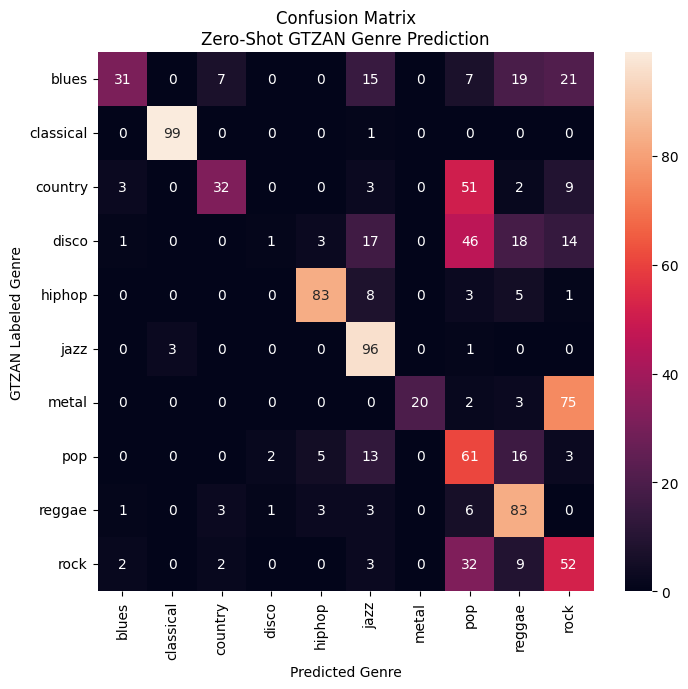

In [153]:
cm = confusion_matrix_from_distance_matrix(dist, labels=infer_results['gtzan_genre_numeric'])

cm = pd.DataFrame(cm, index=genre_embeds['genre'], columns=genre_embeds['genre'])

import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 7))

sns.heatmap(cm, annot=True, ax=ax)
ax.set(xlabel='Predicted Genre', ylabel='GTZAN Labeled Genre',
       title="Confusion Matrix\nZero-Shot GTZAN Genre Prediction")
plt.savefig("confusion_matrix_genre_gtzan.pdf", bbox_inches="tight")

# CLAP Embeddings

In [ ]:
# !pip install laion-clap
import laion_clap

model = laion_clap.CLAP_Module(enable_fusion=False, amodel='HTSAT-base')
model.load_ckpt('checkpoints/laion_clap/music_audioset_epoch_15_esc_90.14.pt')

# embed the model completions
clap_embeds = model.get_text_embedding(infer_results['model_completion_text'].tolist())
infer_results['model_completion_text_clap_embed'] = clap_embeds.tolist()

# embed the genres
genre_embeds = {}
for genre in infer_results.gtzan_genre.unique():
    genre_embeds[genre] = embed_fn(genre)

genre_embeds = pd.DataFrame([(k, v) for k, v in genre_embeds.items()], columns=['genre', 'distilbert_embedding']) \
    .sort_values('genre') \
    .reset_index(drop=True)

genre_embeds.head()

In [ ]:
dist = cosine_distances(np.row_stack(infer_results['model_completion_text_clap_embed'].tolist()),
                        np.row_stack(genre_embeds['clap_embedding'].apply(json.loads).values))

plot_data = []
for k in range(1, 10):
    acc = acc_at_k(dist, k=k, labels=infer_results['gtzan_genre_numeric'])
    plot_data.append((k, acc))

genre_results_at_k = pd.DataFrame(plot_data, columns=["k", "acc@k"])

plt.plot(genre_results_at_k["k"],
         genre_results_at_k["acc@k"],
         "-o",
         label="Music2text Acc@k")
plt.plot(genre_results_at_k["k"],
         genre_results_at_k["k"] / 10,
         "-o",
         label="random baseline")
plt.scatter(x=1, y=0.71, marker="*", s=128, color="darkgrey", label="current known zero-shot SOTA")
plt.scatter(x=1, y=true_genre_in_completion_text, s=128, marker="*", label="true genre in Music2text output")
plt.grid()
plt.legend()
plt.title("Zero-Shot Genre Acc@K\nGTZAN Dataset, CLAP Embeddings")
plt.xlabel("k")

plot_data

In [ ]:
cm = confusion_matrix_from_distance_matrix(dist, labels=infer_results['gtzan_genre_numeric'])

cm = pd.DataFrame(cm, index=genre_embeds['genre'], columns=genre_embeds['genre'])

import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 7))

sns.heatmap(cm, annot=True, ax=ax)
ax.set(xlabel='Predicted Genre', ylabel='GTZAN Labeled Genre',
       title="Confusion MAtrix\nZero-Shot GTZAN Genre Prediction")